In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import sklearn

from sklearn import linear_model
from scipy import stats

from sklearn.linear_model import LinearRegression
from geopy.distance import distance

In [2]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
#                                                     for i in range(sse.shape[0])
#                     ])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [57]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [58]:
earnings = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_taxpayer_income.csv'))

In [59]:
earnings.dropna(inplace=True)

In [60]:
def getYear(series):
    series['year'] = int(series['year'][-4:])
    return series

In [61]:
earnings = earnings.apply(getYear, axis=1)

In [62]:
earnings.head()

,year,area_code,area,population,mean_income,median_income
0,2000,00AA,City of London,10000,109800,40400
1,2001,00AA,City of London,10000,137000,65000
2,2002,00AA,City of London,12000,92900,38300
3,2003,00AA,City of London,11000,78700,37000
4,2004,00AA,City of London,10000,85800,39200


In [63]:
earnings_per_area = earnings.pivot(index='area', columns='year', values='median_income')

In [64]:
earnings_per_area.head()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018
area,,,,,,,,,,,,,,,,,,
Barking and Dagenham,15100,15600,16200,17000,17400,16600,17900,17600,18600,19400,19400,19600,20100,21000,21800,22100,23300,23900
Barnet,18700,19400,18700,19700,20000,19900,21200,20400,22000,24300,24100,24200,25800,26800,27100,27700,28800,28700
Bexley,17200,17300,18300,17800,17700,17700,19400,19600,19800,22100,22600,22300,23100,24400,24400,24500,26100,26900
Brent,16500,16800,16500,16400,16800,16500,17600,18200,18300,19600,19700,20200,20600,21300,22700,23200,24100,24700
Bromley,18500,19500,19100,20100,21400,20900,22400,23000,23200,24900,25800,25100,26900,27200,28100,29800,30400,32000


In [11]:
earnings_per_area.interpolate(inplace=True)

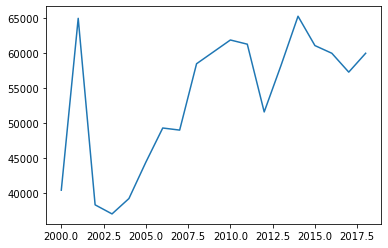

In [12]:
plt.plot(earnings_per_area.loc['City of London'])

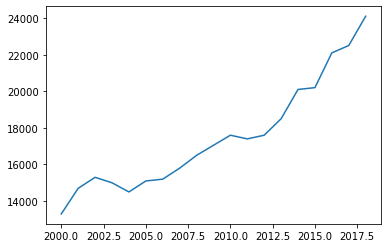

In [13]:
plt.plot(earnings_per_area.loc['Newham'])

Find difference in slopes before and after olympics
===================================================

In [14]:
before_olympics = earnings_per_area.loc[:, :2012]
after_olympics = earnings_per_area.loc[:, 2012:]

In [15]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [16]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [17]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / earnings_per_area.mean(axis=1)

In [18]:
slopes.head()

,before,after,diff
area,,,
Barking and Dagenham,370.391872,728.571429,0.018819
Barnet,507.692308,728.571429,0.009523
Bexley,481.567489,710.714286,0.010820
Brent,335.994194,800.000000,0.023884
Bromley,613.497823,1082.142857,0.019246


Load london borough shape data
==============================

In [19]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [20]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.414 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [21]:
london_regions = map_df.NAME

In [22]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [23]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [24]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon_new/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


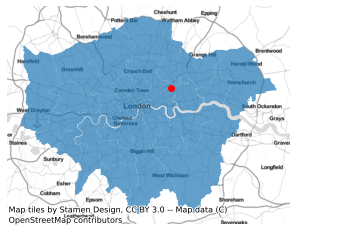

In [25]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [26]:
merged = map_df.set_index('NAME').join(slopes)

In [87]:
int_series = pd.Series(0.7, index=map_df.NAME)
int_series[['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']] = 1.

merged['interesting'] = int_series

In [124]:
dissolved_shapes = merged.dissolve(by='interesting')

In [128]:
dissolved_shapes.drop([0.7], axis=0, inplace=True)

/Users/edwardli/anaconda3/envs/datathon_new/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  if sys.path[0] == '':


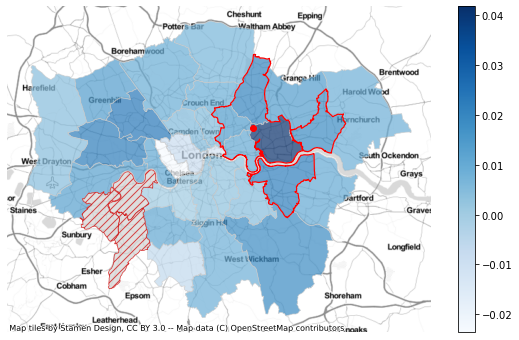

In [143]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True, missing_kwds={
         "color": "lightgrey",
         "edgecolor": "#d00000",
         "hatch": "///",
         "label": "Missing values",
     })

dissolved_shapes.boundary.plot(ax=ax, color='red', linewidth=1.2)

geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig("income_slope.png", dpi=150, bbox_inches='tight')

In [90]:
slopes

,before,after,diff
area,,,
Barking and Dagenham,370.391872,728.571429,0.018819
Barnet,507.692308,728.571429,0.009523
Bexley,481.567489,710.714286,0.010820
Brent,335.994194,800.000000,0.023884
Bromley,613.497823,1082.142857,0.019246
Camden,951.814224,1103.571429,0.005515
City of London,1302.031930,639.285714,-0.012454
Croydon,521.480406,707.142857,0.008578
Ealing,401.306241,882.142857,0.022806


In [91]:
merged['before'] = merged['before'] / earnings_per_area.mean(axis=1)

In [92]:
merged['before']['City of London'] = 0

/Users/edwardli/anaconda3/envs/datathon_new/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
merged['before']

NAME
Kingston upon Thames               NaN
Croydon                   1.113128e-06
Bromley                   1.034702e-06
Hounslow                  1.215768e-06
Ealing                    9.028121e-07
Havering                  1.311093e-06
Hillingdon                1.229323e-06
Harrow                    8.996633e-07
Brent                     8.901958e-07
Barnet                    9.436971e-07
Lambeth                   1.469181e-06
Southwark                 1.660192e-06
Lewisham                  1.559000e-06
Greenwich                 1.091485e-06
Bexley                    1.073733e-06
Enfield                   1.187147e-06
Waltham Forest            1.159806e-06
Redbridge                 1.131334e-06
Sutton                    1.409682e-06
Richmond upon Thames               NaN
Merton                    1.024624e-06
Wandsworth                1.210949e-06
Hammersmith and Fulham    1.111214e-06
Kensington and Chelsea    1.229674e-06
Westminster               1.315701e-06
Camden              

In [94]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [95]:
mdists = map_df.set_index('NAME').join(dists)

/Users/edwardli/anaconda3/envs/datathon_new/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


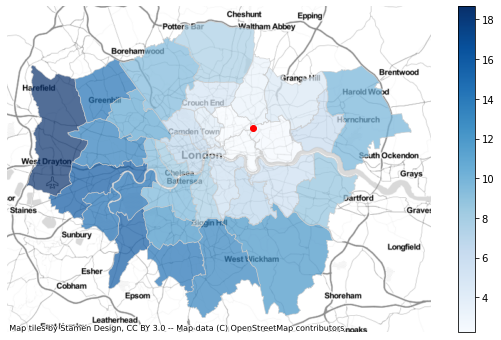

In [96]:
fig, ax = plt.subplots(1, figsize=(10, 6))
mdists.plot(column='Distance', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

/Users/edwardli/anaconda3/envs/datathon_new/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


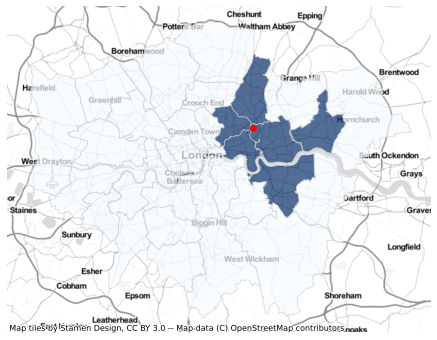

In [101]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='interesting', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig("east_london.png", dpi=150, bbox_inches='tight')

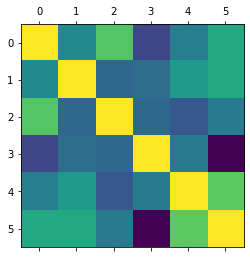

In [37]:
plt.matshow(mdists.join(slopes).corr())

In [38]:
mdists.join(slopes).corr()

,HECTARES,NONLD_AREA,Distance,before,after,diff
HECTARES,1.000000,0.032552,0.509195,-0.448645,-0.054453,0.269038
NONLD_AREA,0.032552,1.000000,-0.228227,-0.182622,0.150869,0.280429
Distance,0.509195,-0.228227,1.000000,-0.225531,-0.337961,-0.079001
before,-0.448645,-0.182622,-0.225531,1.000000,-0.086022,-0.841967
after,-0.054453,0.150869,-0.337961,-0.086022,1.000000,0.533997
diff,0.269038,0.280429,-0.079001,-0.841967,0.533997,1.000000


In [39]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [40]:
profiles.set_index('Area_name').loc['Newham']

Code                                                            E09000025
Inner/_Outer_London                                          Inner London
GLA_Population_Estimate_2017                                       342900
GLA_Household_Estimate_2017                                        119172
Inland_Area_(Hectares)                                              3,620
                                                                 ...     
Political_control_in_council                                          Lab
Proportion_of_seats_won_by_Conservatives_in_2014_election               0
Proportion_of_seats_won_by_Labour_in_2014_election                    100
Proportion_of_seats_won_by_Lib_Dems_in_2014_election                    0
Turnout_at_2014_local_elections                                      40.5
Name: Newham, Length: 83, dtype: object

In [41]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                          0.006870
Average_Age,_2017                                    -0.466123
Proportion_of_population_aged_0-15,_2015              0.602706
Proportion_of_population_of_working-age,_2015        -0.236992
Proportion_of_population_aged_65_and_over,_2015      -0.236456
New_migrant_(NINo)_rates,_(2015/16)                   0.047012
Employment_rate_(%)_(2015)                           -0.031742
%_of_employment_that_is_in_public_sector_(2014)       0.379076
Jobs_Density,_2015                                   -0.355299
Number_of_active_businesses,_2015                    -0.000064
Two-year_business_survival_rates_(started_in_2013)    0.183995
Number_of_cars,_(2011_Census)                         0.005299
Number_of_cars_per_household,_(2011_Census)           0.187055
%_children_living_in_out-of-work_households_(2015)    0.159092
Life_satisfaction_score_2011-14_(out_of_10)          -0.100816
Worthwhileness_score_2011-14_(out_of_10)             -0

In [42]:
profiles.set_index('Area_name').join(dists).corr().loc['Distance']

GLA_Population_Estimate_2017                          0.035107
Average_Age,_2017                                     0.416243
Proportion_of_population_aged_0-15,_2015              0.142736
Proportion_of_population_of_working-age,_2015        -0.535341
Proportion_of_population_aged_65_and_over,_2015       0.549599
New_migrant_(NINo)_rates,_(2015/16)                  -0.468055
Employment_rate_(%)_(2015)                            0.530636
%_of_employment_that_is_in_public_sector_(2014)      -0.316548
Jobs_Density,_2015                                   -0.201112
Number_of_active_businesses,_2015                    -0.197319
Two-year_business_survival_rates_(started_in_2013)    0.566712
Number_of_cars,_(2011_Census)                         0.570414
Number_of_cars_per_household,_(2011_Census)           0.715940
%_children_living_in_out-of-work_households_(2015)   -0.610379
Life_satisfaction_score_2011-14_(out_of_10)           0.480959
Worthwhileness_score_2011-14_(out_of_10)              0

In [43]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

ModuleNotFoundError: No module named 'factor_analyzer'

In [ ]:
fa = FactorAnalyzer()

In [ ]:
all_things = profiles.set_index('Area_name').join(dists).join(slopes)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = all_things.select_dtypes(include=numerics)
newdf.dropna(inplace=True)

In [ ]:
x_test = newdf.drop(['before', 'after', 'diff', 'Proportion_of_population_aged_0-15,_2015', 'Proportion_of_population_of_working-age,_2015', 'Proportion_of_population_aged_65_and_over,_2015'], axis=1)

In [ ]:
reg_diff = LinearRegression()

reg_diff.fit(x_test, newdf['diff'])

In [ ]:
reg_diff.coef_

In [ ]:
plt.bar(x_test.columns, reg_diff.p[0])
plt.xticks(rotation=90)

In [ ]:
reg_second = LinearRegression()
reg_second.fit(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']], newdf['diff'])

In [ ]:
sklearn.metrics.r2_score(newdf['diff'], reg_second.predict(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']]))

In [ ]:
reg_diff.p[reg_diff.p < 0.05]

In [ ]:
y_preds = reg_diff.predict(x_test)

In [ ]:
sklearn.metrics.r2_score(newdf['diff'], y_preds)

In [ ]:
plt.bar(x_test.columns, abs(reg_diff.coef_))
plt.xticks(rotation=90)

In [ ]:
fa.fit(newdf)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.matshow(fa.loadings_)
ax.set_yticks(range(len(newdf.columns)))
ax.set_yticklabels(newdf.columns)

In [ ]:
fa.loadings_

In [ ]:
calculate_kmo(newdf)

In [ ]:
calculate_bartlett_sphericity(newdf)

In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(newdf, 25)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

Wealth Gap
==========

In [44]:
olympic_boroughs = ['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']

In [45]:
def split_olympics(series):
    
    return pd.Series({
        'olympic_avg': series[olympic_boroughs].median(),
        'nonolympic_avg': series[~series.index.isin(olympic_boroughs)].median(),
        'total_avg': series.median()
    })

In [46]:
earnings.head()

,year,area_code,area,population,mean_income,median_income
0,2000,00AA,City of London,10000,109800,40400
1,2001,00AA,City of London,10000,137000,65000
2,2002,00AA,City of London,12000,92900,38300
3,2003,00AA,City of London,11000,78700,37000
4,2004,00AA,City of London,10000,85800,39200


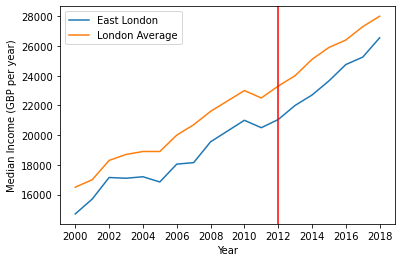

In [73]:
plt.plot(earnings[earnings.area.isin(olympic_boroughs)].pivot_table(index='year', values='median_income', aggfunc=np.median), label='East London')
plt.plot(earnings[earnings.area.isin(london_regions)].pivot_table(index='year', values='median_income', aggfunc=np.median), label='London Average')
plt.xticks(range(2000, 2019, 2))
plt.axvline(2012, color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Median Income (GBP per year)')
plt.savefig("median_income.png", bbox_inches='tight', dpi=150)

In [48]:
olympic_avg = earnings[earnings.area.isin(olympic_boroughs)].pivot_table(index='year', values='median_income', aggfunc=np.median)
overall_avg = earnings[earnings.area.isin(london_regions)].pivot_table(index='year', values='median_income', aggfunc=np.median)

In [49]:
income_gap = overall_avg - olympic_avg

In [50]:
income_reg = LinearRegression()

income_reg.fit(income_gap.index.to_numpy().reshape(-1, 1), income_gap.median_income)

LinearRegression()

(0.0, 2620.0)

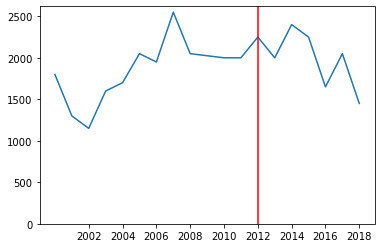

In [51]:
f, ax = plt.subplots(1)
ax.plot(overall_avg - olympic_avg)
# ax.plot(income_gap.index, income_reg.predict(income_gap.index.to_numpy().reshape(-1, 1)))
plt.xticks(range(2002, 2019, 2))
plt.axvline(2012, color='red')
ax.set_ylim(bottom=0)

In [52]:
income_info = earnings_per_area.apply(split_olympics)

In [53]:
income_info

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018
olympic_avg,14700.0,15700.0,17150.0,17100.0,17200.0,16850.0,18050.0,18150.0,19550.0,21000.0,20500.0,21050.0,22000.0,22700.0,23650.0,24750.0,25250.0,26550.0
nonolympic_avg,16100.0,16900.0,17600.0,18100.0,18800.0,18400.0,20000.0,20400.0,20900.0,22300.0,22200.0,22700.0,23300.0,24400.0,25300.0,25900.0,26100.0,27300.0
total_avg,15700.0,16600.0,17600.0,17900.0,18200.0,18300.0,19400.0,19600.0,20800.0,22100.0,22000.0,22700.0,23200.0,24300.0,25100.0,25800.0,26100.0,27300.0


In [54]:
income_info.transpose().plot.line

<bound method PlotAccessor.line of <pandas.plotting._core.PlotAccessor object at 0x7fb5c6b15410>>

In [65]:
income_info[2015]

olympic_avg       23650.0
nonolympic_avg    25300.0
total_avg         25100.0
Name: 2015, dtype: float64

In [ ]:
income_info[2015]['total_avg'] - income_info[2015]['olympic_avg']

Population
==========

In [ ]:
earnings.head()

In [ ]:
earnings[earnings.area == 'Newham'].set_index('year').population.plot.line()

In [ ]:
earnings[earnings.area == 'Barking and Dagenham'].population.plot.line()